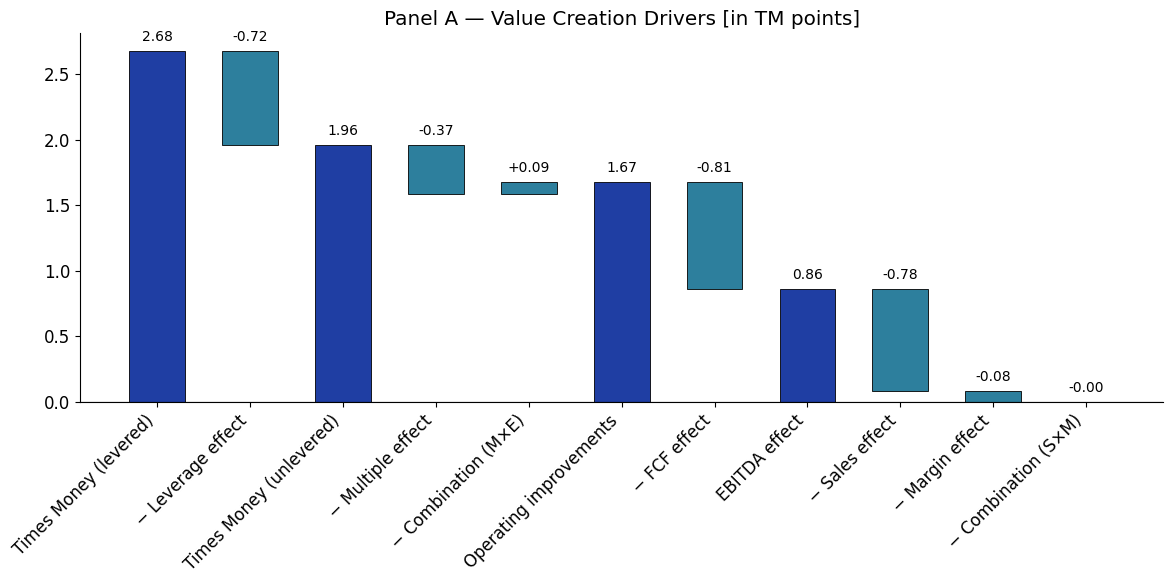

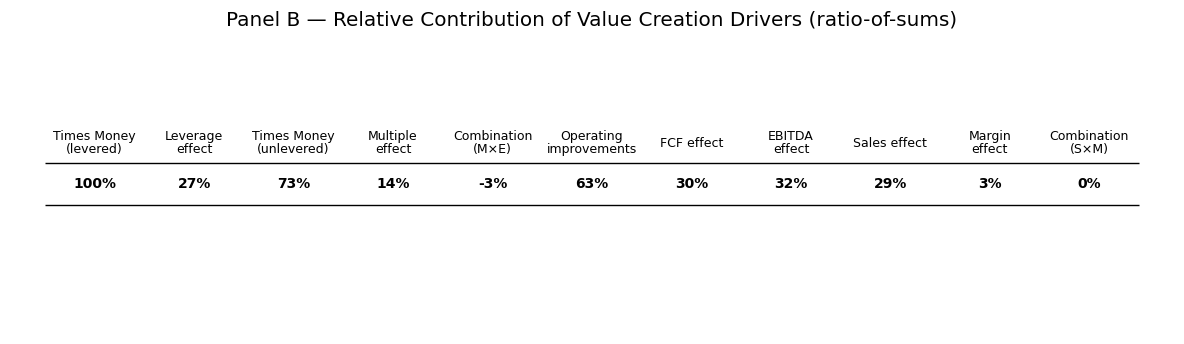


--- Panel A: TM-point means ---
Times Money (levered)                        2.6767
Leverage effect                              0.7169
Times Money (unlevered)                      1.9598
Multiple effect                              0.3711
Combination (M×E)                           -0.0852
Operating improvements (TMU − Multiple − M×E)     1.6739
FCF effect                                   0.8135
EBITDA effect                                0.8604
Sales effect                                 0.7794
Margin effect                                0.0801
Combination (S×M)                            0.0009

--- Panel B (ratio-of-sums, % of levered TM) ---
Times Money (levered)         100.0%
Leverage effect                26.8%
Times Money (unlevered)        73.2%
Multiple effect                13.9%
Combination (M×E)              -3.2%
Operating improvements         62.5%
FCF effect                     30.4%
EBITDA effect                  32.1%
Sales effect                   29.1%
Margin 

In [64]:
# === Analysis + Plots: TM-point means (Panel A) and ratio-of-sums (Panel B) ===

import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
import textwrap

# ---- helper ----
def find_upwards(rel_path: Path, max_up: int = 8) -> Path:
    here = Path.cwd()
    for parent in [here, *here.parents][: max_up + 1]:
        candidate = (parent / rel_path)
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError(
        f"Couldn't locate '{rel_path.as_posix()}' from {here} by walking up {max_up} levels.\n"
        f"- Current working directory: {here}\n"
        f"- Checked: {[str((p / rel_path)) for p in [here, *here.parents][: max_up + 1]]}"
    )

# ---- load ----
TARGET_CSV = (find_upwards(Path("ValueCreation")) / "Data" / "working.csv")
df = pd.read_csv(TARGET_CSV)

# FILTER FOR SAMPLE DEAL (optional)
#df = df.loc[df["deal_id"] == "111d1"].copy()
#assert not df.empty, "Sample deal_id '111d1' not found."
#assert df["deal_id"].nunique() == 1

# ----- collapse to one row per deal -----
numeric_cols = [
    "times_money","leverage_effect","tm_unlevered",
    "tmu_contrib_multiple_effect",
    "tmu_contrib_multiple_ebitda_combination_effect",
    "tmu_contrib_fcf_effect",
    "tmu_contrib_ebitda_effect",
    "tmu_contrib_sales_effect",
    "tmu_contrib_margin_effect",
    "tmu_contrib_sales_margin_combination_effect",
]

# fail loudly if expected columns are missing
missing = [c for c in numeric_cols if c not in df.columns]
assert not missing, f"Missing expected columns: {missing}"

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# by construction these are deal-level duplicates; take first per deal_id
deal = df.groupby("deal_id", as_index=False)[numeric_cols].first()

# ---- trimming ----
p = 0.10
if deal.shape[0] < 20:
    p = 0.0  # avoid pathological trims on tiny samples

lo, hi = deal["times_money"].quantile([p, 1 - p])
D = deal.query("times_money >= @lo and times_money <= @hi").copy()
assert not D.empty, "Trim produced an empty sample."

# ---- means on trimmed deal-level data ----
m = D[numeric_cols].mean()

tm   = m["times_money"]
lev  = m["leverage_effect"]
tmu  = m["tm_unlevered"]
mult = m["tmu_contrib_multiple_effect"]
comb = m["tmu_contrib_multiple_ebitda_combination_effect"]
fcf  = m["tmu_contrib_fcf_effect"]
ebit = m["tmu_contrib_ebitda_effect"]
sale = m["tmu_contrib_sales_effect"]
marg = m["tmu_contrib_margin_effect"]
smc  = m["tmu_contrib_sales_margin_combination_effect"]

# ---- PANEL A: connected main bridge + single EBITDA drill-down ----
plt.rcParams.update({'font.size': 12})
figA, axA = plt.subplots(figsize=(12, 6))

MAIN_COLOR = "#1f3ea3"
STEP_COLOR = "#2d7f9d"

steps_main = [
    ("Times Money (levered)",      "start",    tm),
    ("− Leverage effect",          "delta",   -lev),
    ("Times Money (unlevered)",    "subtotal", None),
    ("− Multiple effect",          "delta",   -mult),
    ("− Combination (M×E)",        "delta",   -comb),
    ("Operating improvements",     "subtotal", None),
    ("− FCF effect",               "delta",   -fcf),
]
x_main = list(range(len(steps_main)))
prev = 0.0; bottoms=[]; heights=[]; labels=[]; kinds=[]; vals=[]; colors=[]
for lab, kind, val in steps_main:
    labels.append(lab); kinds.append(kind); vals.append(val)
    if kind == "start":
        bottoms.append(0.0); heights.append(val); prev = val; colors.append(MAIN_COLOR)
    elif kind == "delta":
        new = prev + val
        bottoms.append(min(prev, new)); heights.append(abs(val)); prev = new; colors.append(STEP_COLOR)
    else:  # subtotal
        bottoms.append(0.0); heights.append(prev); colors.append(MAIN_COLOR)

axA.bar(x_main, heights, bottom=bottoms, width=0.6, edgecolor="black", linewidth=0.6, color=colors)

ymin, ymax = axA.get_ylim()
offset = 0.02 * (ymax - ymin)
for xi, (kind, h, b, v) in enumerate(zip(kinds, heights, bottoms, vals)):
    top_edge = b + h
    txt = f"{h:.2f}" if kind in ("start","subtotal") else f"{v:+.2f}"
    axA.text(xi, top_edge + offset, txt, ha="center", va="bottom", fontsize=10)

# EBITDA drill-down
x0 = len(steps_main)
drill_labels = ["EBITDA effect","− Sales effect","− Margin effect","− Combination (S×M)"]
drill_kinds  = ["subtotal",     "delta",         "delta",          "delta"]
drill_vals   = [None,           -sale,           -marg,            -smc]

drill_bottoms = [0.0]; drill_heights = [ebit]; drill_colors = [MAIN_COLOR]
prev_e = ebit
for v in drill_vals[1:]:
    new_e = prev_e + v
    drill_bottoms.append(min(prev_e, new_e))
    drill_heights.append(abs(v))
    drill_colors.append(STEP_COLOR)
    prev_e = new_e

x_drill = list(range(x0, x0 + len(drill_labels)))
axA.bar(x_drill, drill_heights, bottom=drill_bottoms, width=0.6, edgecolor="black", linewidth=0.6, color=drill_colors)

for xi, (lab, kind, h, b, v) in enumerate(zip(drill_labels, drill_kinds, drill_heights, drill_bottoms, drill_vals)):
    xi_abs = x_drill[xi]
    top_edge = b + h
    txt = f"{h:.2f}" if kind == "subtotal" else f"{v:+.2f}"
    axA.text(xi_abs, top_edge + offset, txt, ha="center", va="bottom", fontsize=10)

axA.set_xticks(x_main + x_drill)
axA.set_xticklabels(labels + drill_labels, rotation=45, ha='right')
axA.set_title("Panel A — Value Creation Drivers [in TM points]")
axA.axhline(0, color='black', linewidth=0.8)
axA.spines['top'].set_visible(False)
axA.spines['right'].set_visible(False)

figA.tight_layout()
# figA.savefig("panelA_tm_bridge.png", dpi=200, bbox_inches="tight")
plt.show()

# ==== Panel B data (ratio-of-sums) ====
tm_s   = D["times_money"]
lev_s  = D["leverage_effect"]
tmu_s  = D["tm_unlevered"]
mult_s = D["tmu_contrib_multiple_effect"]
comb_s = D["tmu_contrib_multiple_ebitda_combination_effect"]
fcf_s  = D["tmu_contrib_fcf_effect"]
ebit_s = D["tmu_contrib_ebitda_effect"]
sale_s = D["tmu_contrib_sales_effect"]
marg_s = D["tmu_contrib_margin_effect"]
smc_s  = D["tmu_contrib_sales_margin_combination_effect"]

den = tm_s.sum()
assert abs(den) > 1e-12, "Sum of TM is ~0; ratio-of-sums is unstable."

panelB_ros = pd.Series({
    "Times Money (levered)"  : 1.0,
    "Leverage effect"        : lev_s.sum()  / den,
    "Times Money (unlevered)": tmu_s.sum()  / den,
    "Multiple effect"        : mult_s.sum() / den,
    "Combination (M×E)"      : comb_s.sum() / den,
    "Operating improvements" : (fcf_s.sum() + ebit_s.sum()) / den,
    "FCF effect"             : fcf_s.sum()  / den,
    "EBITDA effect"          : ebit_s.sum() / den,
    "Sales effect"           : sale_s.sum() / den,
    "Margin effect"          : marg_s.sum() / den,
    "Combination (S×M)"      : smc_s.sum()  / den,
}).mul(100)

# robust: exclude tiny-|TM| deals for percentages only
eps = 0.05
mask_robust = tm_s.abs() >= eps
den_r = tm_s[mask_robust].sum()
assert abs(den_r) > 1e-12, "Robust denominator ~0; robust ratio-of-sums is unstable."

panelB_ros_robust = pd.Series({
    "Times Money (levered)"  : 1.0,
    "Leverage effect"        : lev_s[mask_robust].sum()  / den_r,
    "Times Money (unlevered)": tmu_s[mask_robust].sum()  / den_r,
    "Multiple effect"        : mult_s[mask_robust].sum() / den_r,
    "Combination (M×E)"      : comb_s[mask_robust].sum() / den_r,
    "Operating improvements" : (fcf_s[mask_robust].sum() + ebit_s[mask_robust].sum()) / den_r,
    "FCF effect"             : fcf_s[mask_robust].sum()  / den_r,
    "EBITDA effect"          : ebit_s[mask_robust].sum() / den_r,
    "Sales effect"           : sale_s[mask_robust].sum() / den_r,
    "Margin effect"          : marg_s[mask_robust].sum() / den_r,
    "Combination (S×M)"      : smc_s[mask_robust].sum()  / den_r,
}).mul(100)


# --- Hierarchical reconciliation checks (percent units) ---
def chk_close(name, lhs, rhs, tol=1e-4):  # was 1e-6
    resid = float(lhs - rhs)
    if abs(resid) > tol:
        print(f"Warning: {name} off by {resid:+.6f} pp.")

keys_atomic = ["Leverage effect","Multiple effect","Combination (M×E)","FCF effect","EBITDA effect"]

# Level 0
sum_atomic_all = panelB_ros[keys_atomic].sum()
chk_close("Level 0 (Lev + atomics vs 100%)", sum_atomic_all, 100.0)

# Level 1
sum_tmu_components = (panelB_ros["Multiple effect"]
                      + panelB_ros["Combination (M×E)"]
                      + panelB_ros["FCF effect"]
                      + panelB_ros["EBITDA effect"])
chk_close("Level 1 (components vs TMU)", sum_tmu_components, panelB_ros["Times Money (unlevered)"])

# Level 2
sum_ebitda_sub = (panelB_ros["Sales effect"]
                  + panelB_ros["Margin effect"]
                  + panelB_ros["Combination (S×M)"])
chk_close("Level 2 (sales+margin+S×M vs EBITDA)", sum_ebitda_sub, panelB_ros["EBITDA effect"])

# Robust variants
sum_atomic_all_r = panelB_ros_robust[keys_atomic].sum()
chk_close("Level 0 ROBUST (Lev + atomics vs 100%)", sum_atomic_all_r, 100.0)

sum_tmu_components_r = (panelB_ros_robust["Multiple effect"]
                        + panelB_ros_robust["Combination (M×E)"]
                        + panelB_ros_robust["FCF effect"]
                        + panelB_ros_robust["EBITDA effect"])
chk_close("Level 1 ROBUST (components vs TMU)", sum_tmu_components_r, panelB_ros_robust["Times Money (unlevered)"])

sum_ebitda_sub_r = (panelB_ros_robust["Sales effect"]
                    + panelB_ros_robust["Margin effect"]
                    + panelB_ros_robust["Combination (S×M)"])
chk_close("Level 2 ROBUST (sales+margin+S×M vs EBITDA)", sum_ebitda_sub_r, panelB_ros_robust["EBITDA effect"])

# ---- PANEL B figure ----
headers = list(panelB_ros.index)
values  = [panelB_ros[h] for h in headers]

figB, axB = plt.subplots(figsize=(12, 3.6))
axB.set_axis_off()

n = len(headers)
left_margin, right_margin = 0.03, 0.97
xs = left_margin + (np.arange(n) + 0.5) * (right_margin - left_margin) / n

y_sep1 = 0.57
y_sep2 = 0.43
y_header = y_sep1 + 0.065
y_value  = 0.50

wrap_w = 12
for x, hdr, val in zip(xs, headers, values):
    axB.text(x, y_header, textwrap.fill(hdr, width=wrap_w),
             ha="center", va="center", fontsize=9, linespacing=1.05, transform=axB.transAxes)
    axB.text(x, y_value, f"{val:.0f}%", ha="center", va="center",
             fontsize=10, fontweight="bold", transform=axB.transAxes)

axB.hlines([y_sep1, y_sep2], xmin=left_margin, xmax=right_margin,
           colors="black", linewidth=1.0, transform=axB.transAxes)

axB.set_title("Panel B — Relative Contribution of Value Creation Drivers (ratio-of-sums)", pad=6)

figB.tight_layout()
# figB.savefig("panelB_ratio_of_sums.png", dpi=200, bbox_inches="tight")
plt.show()

# ==== PRINT VALUES UNDER EACH PANEL ====
# Panel A — absolute TM-point means (same order as bars)
panelA_labels = [
    "Times Money (levered)",
    "Leverage effect",
    "Times Money (unlevered)",
    "Multiple effect",
    "Combination (M×E)",
    "Operating improvements (TMU − Multiple − M×E)",
    "FCF effect",
    "EBITDA effect",
    "Sales effect",
    "Margin effect",
    "Combination (S×M)",
]
op = tmu - (mult + comb)

panelA_values = [tm, lev, tmu, mult, comb, op, fcf, ebit, sale, marg, smc]

print("\n--- Panel A: TM-point means ---")
for lab, val in zip(panelA_labels, panelA_values):
    print(f"{lab:40s} {val:>10.4f}")

# Panel B printed values (non-robust)
print("\n--- Panel B (ratio-of-sums, % of levered TM) ---")
for lab in headers:
    print(f"{lab:28s} {panelB_ros[lab]:6.1f}%")
print(f"Deals used: {int(D.shape[0])}  (no |TM| filter)")

# Panel B printed values (robust)
print(f"\n--- Panel B (robust ratio-of-sums, % of levered TM; exclude |TM|<{eps}) ---")
for lab in headers:
    print(f"{lab:28s} {panelB_ros_robust[lab]:6.1f}%")
print(f"Deals used: {int(mask_robust.sum())}  (excluded {int((~mask_robust).sum())} tiny-|TM| deals)")

# Sample / trim diagnostics
n_total = int(deal.shape[0])
n_kept  = int(D.shape[0])
print("\n--- Sample diagnostics ---")
print(f"Deals total (pre-trim): {n_total}")
print(f"Deals kept (post-trim): {n_kept}")
print(f"Two-sided trim p = {p:.2%}")
print(f"TM trim thresholds: low={lo:.4f}, high={hi:.4f}")

# Identities (per deal)
idc = pd.DataFrame({
    "tmu_minus_parts": (tmu_s - (mult_s + comb_s + fcf_s + ebit_s)),
    "ebit_minus_subs": (ebit_s - (sale_s + marg_s + smc_s)),
})
print("\nIdentities (per deal):")
print("  |tmu − (mult+comb+fcf+ebit)| > 1e-9  ->", int((idc["tmu_minus_parts"].abs() > 1e-9).sum()))
print("  |ebit − (sales+marg+smc)|   > 1e-9  ->", int((idc["ebit_minus_subs"].abs() > 1e-9).sum()))

# Potentially unstable denominators for per-deal shares
tm_abs = tm_s.abs()
print("\nPotentially unstable denominators (levered TM):")
for thr in [0.01, 0.05, 0.10]:
    print(f"  Count with |TM| < {thr:.2f}: {int((tm_abs < thr).sum())}")

# Effect summaries (deal-level, trimmed)
summary = pd.DataFrame({
    "mean":   [tm_s.mean(), lev_s.mean(), tmu_s.mean(), mult_s.mean(), comb_s.mean(), fcf_s.mean(), ebit_s.mean(), sale_s.mean(), marg_s.mean(), smc_s.mean()],
    "median": [tm_s.median(), lev_s.median(), tmu_s.median(), mult_s.median(), comb_s.median(), fcf_s.median(), ebit_s.median(), sale_s.median(), marg_s.median(), smc_s.median()],
    "p10":    [tm_s.quantile(0.1), lev_s.quantile(0.1), tmu_s.quantile(0.1), mult_s.quantile(0.1), comb_s.quantile(0.1), fcf_s.quantile(0.1), ebit_s.quantile(0.1), sale_s.quantile(0.1), marg_s.quantile(0.1), smc_s.quantile(0.1)],
    "p90":    [tm_s.quantile(0.9), lev_s.quantile(0.9), tmu_s.quantile(0.9), mult_s.quantile(0.9), comb_s.quantile(0.9), fcf_s.quantile(0.9), ebit_s.quantile(0.9), sale_s.quantile(0.9), marg_s.quantile(0.9), smc_s.quantile(0.9)],
}, index=["TM","Lev","TMU","Mult","Comb","FCF","EBITDA","Sales","Margin","S×M"]).round(4)

print("\nEffect summaries (deal-level, trimmed):")
print(summary)

res1 = (tmu_s - (mult_s + comb_s + fcf_s + ebit_s)).abs()
print("Max |tmu − parts|:", float(res1.max()), "  95th pct:", float(res1.quantile(0.95)))
